# Color analysis of coral fragments

For simplicity, we will use the pre-processed data in the `data/interim` folder. The data is already cleaned and ready for analysis.

### Load all the required libraries

In [11]:
from manipulation_library_dev import plot_compare_mapped_image_save, get_image, get_colors, OcrAnalysis ,is_cuda_available ,show_box
import easyocr , os , ssl
import matplotlib.pyplot as plt
from glob import glob
ssl._create_default_https_context = ssl._create_unverified_context


### Load easyocr library in to a gpu if available

In [12]:
gpu_available = is_cuda_available()
reader = easyocr.Reader(['en'],gpu=gpu_available) # this needs to run only once to load the model into memory

###  Gather all the cropped parts from the images and store them in a list

In [13]:
# Define the path to the folder containing the project
path_to_folder = "/".join(os.getcwd().split("/")[:-1])

# Define the relative path to the folder containing the center segment images
segment = "data/interim/center_fragment"

# Create the absolute path to the folder containing the  center segment images
path_absolute_to_image = os.path.join(path_to_folder, segment)

# Define the pattern to match all JPEG images in the folder
segment_center_images = f"{path_absolute_to_image}/*.jpg"

# Get a list of all center segment images
list_of_center_segment_images = glob(segment_center_images)

# Extract the file names without the '-center' suffix and store them in a list
file_name = [x.split("/")[-1].split("-center")[0] for x in list_of_center_segment_images]

# Define the relative path to the folder containing the images
my_path = "data/interim"

# Create the absolute path to the folder containing the images
path_to_images_folder = os.path.join(path_to_folder, my_path)

# Define the sections of the images
section = ["up", "down", "rigth", "left"]

# Initialize an empty dictionary to store the images
my_images = {}

# Loop through each file name
for f_name in file_name:
    # Initialize an inner dictionary to store the paths of the images for each section
    inner_dict = {}
    
    # Loop through each section
    for sec in section:
        # Create the path to the image for the current section
        image_path = os.path.join(path_to_images_folder, sec, f"{f_name}-{sec}.jpeg")
        
        # Check if the image file exists
        if os.path.isfile(image_path):
            # If the file exists, add it to the inner dictionary
            inner_dict[sec] = image_path
        else:
            # If the file does not exist, print a message
            print(f"file not found: {path_to_images_folder}/{sec}/{f_name}-{sec}.jpeg")
    
    # If the inner dictionary is not empty, add it to the main dictionary
    if inner_dict:
        my_images[f_name] = inner_dict

### Build the custom color chart 
After gathering all the cropped parts from the images, we will build a custom color chart. The custom color chart will be used to compare the colors of the coral fragments with the colors in the custom color chart.

In [14]:
# Initialize an empty dictionary to store the custom color charts
custom_color_charts = {}

# Initialize an empty list to store the file names of the images that are incomplete
incomplete_to_fill = []

# Loop through each file name
for f_name in file_name:
        my_personal_chart = {}

        for sec in section :
            im =  my_images[f_name][sec]
            result = reader.readtext(im)
            bboxes, text_list = OcrAnalysis.get_bounding_boxes(result)

            image = get_image(im)

            for t,bbox in zip(text_list,bboxes):
                cropped_image = OcrAnalysis.get_pixels_above_bbox(bbox=bbox,image=image)
                df_color = get_colors(image=cropped_image, number_of_colors=1, show_chart=False)
                my_personal_chart[t]=tuple( round(x) for x in df_color["rgb_colors"][0].tolist() )

        if my_personal_chart:

            new_keys = ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6']
            if len(new_keys) == len(my_personal_chart.keys()):
                my_personal_chart = {new_keys[i]: my_personal_chart[old_key] for i, old_key in enumerate(my_personal_chart)}
                my_personal_chart["Black"] = tuple([0,0,0])
                my_personal_chart["White"] = tuple([255,255,255])
                custom_color_charts[f_name] = my_personal_chart
            else :
                incomplete_to_fill.append(f_name)


In [15]:
# Fill the incomplete color charts
# The color charts that are incomplete will be filled with the colors of the first complete color chart
# The images come from the same source and experiment
my_custom_keys = [x for x in custom_color_charts.keys()]
for idx , f_name in enumerate (incomplete_to_fill):
    r_name = my_custom_keys[idx]
    print (f"filling {f_name} with {r_name}" )
    custom_color_charts[f_name] ={ key:item for (key,item) in custom_color_charts[r_name].items()}

filling T1_CTRL_Night-4 with T0_CTRL_Day-6
filling T0_CTRL_Night-3 with T1_BMC_Night-3
filling T0_CTRL_Day-3 with T1_CTRL_Day-1


In [16]:
# Check if the color charts have 26 colors
# If the color charts have 26 colors, print the key and the number of colors
# If the color charts do not have 26 colors, print the key and the number of colors
for im in list_of_center_segment_images: 
    # print (im)
    # local_image = get_image(im)
    name = im.split("/")[-1]
    key = im.split("/")[-1].split("-center")[0]
    if key in custom_color_charts.keys():
        if len(custom_color_charts[key]) == 26:
            pass
        else:
            print (key,len(custom_color_charts[key]))

In [17]:

# Save the custom color charts
# The custom color charts will be saved in the 'data/final/fragments_coral_chart_mapped_colors' folder
# The custom color charts will be saved as CSV files
outputs = "data/final/fragments_coral_chart_mapped_colors"
path_absolute_to_output = os.path.join(path_to_folder,outputs)
os.makedirs(path_absolute_to_output ,exist_ok=True)


### Show a sample of the custom color chart mappped to the coral fragments

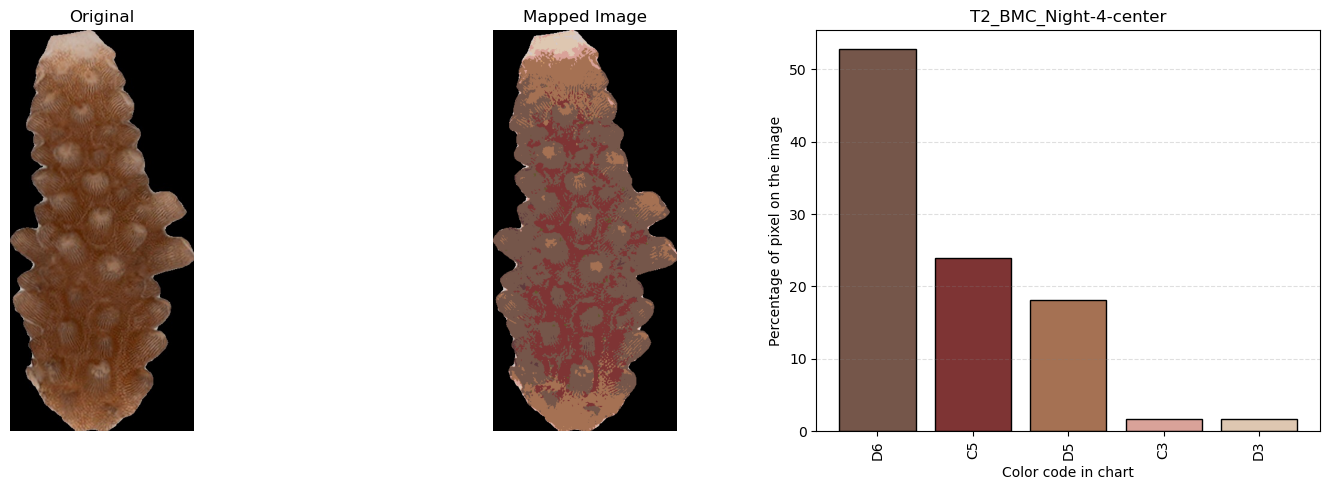

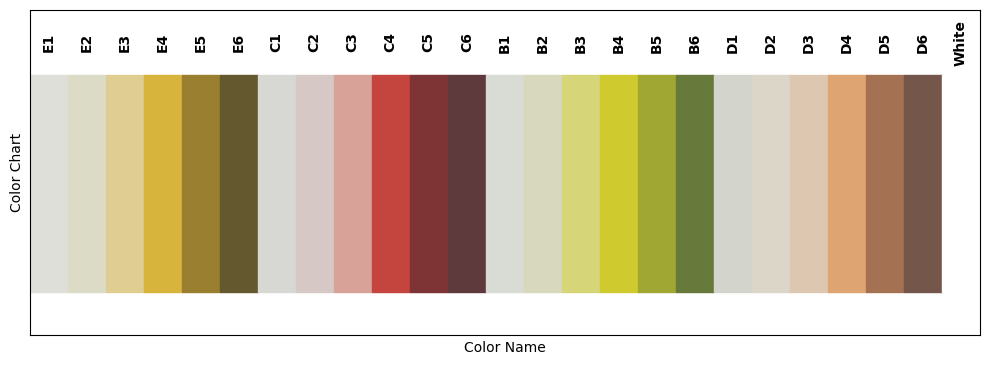

In [18]:

for im in list_of_center_segment_images: 
#    # print (im)
    if "T2_BMC_Night-4" in im : 
        local_image = get_image(im)
        name = im.split("/")[-1]
        key = im.split("/")[-1].split("-center")[0]
        if len(custom_color_charts[key]) == 26:
            path_name = os.path.join(path_absolute_to_output,name)
            plot_compare_mapped_image_save( local_image,path_name,custom_color_charts[key])
            OcrAnalysis.plot_custom_colorchart(custom_color_charts["T2_BMC_Night-4"])
                        
        else:
            print (key,len(custom_color_charts[key]))


### Show how the OCR works on the cropped parts

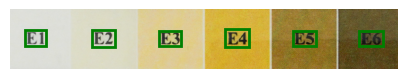

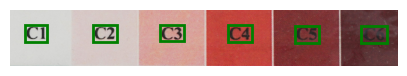

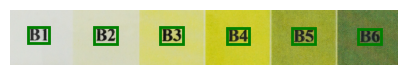

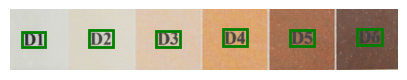

In [19]:
for sec in section :

    im =  my_images["T2_BMC_Night-4"][sec]
    result = reader.readtext(im)
    bboxes, text_list = OcrAnalysis.get_bounding_boxes(result)

    image = get_image(im)
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    # show_mask(masks[0], plt.gca())
    for input_box in bboxes : 
        show_box(input_box, plt.gca())


    plt.axis('off')
    plt.show()


